In [157]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd 
pd.set_option("display.max_columns", 100)
import openpyxl as _ # to make sure it is installed
import numpy as np
import scipy.stats
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper', font_scale=1.3)
from rakott.mpl import fig_panel_labels
plt.rcParams['axes.titlesize'] = 12
red, blue, green = sns.color_palette('Set1', 3)

## Data loading

In [148]:
def load_data(fname, key):
    data = pd.read_excel(fname)

    if key == 'B':
        data.rename(columns={
            'Sample_Avihu1_Fraction_ref':'ancestor_ref', 'Sample_Avihu1_Fraction_alt1':'ancestor_alt',
            'Sample_Avihu1_Reads_ref':'ancestor_ref_count', 'Sample_Avihu1_Reads_alt1':'ancestor_alt_count', 
            'Sample_Avihu2_Fraction_ref':'aneuploidy_ref', 'Sample_Avihu2_Fraction_alt1':'aneuploidy_alt',
            'Sample_Avihu4_Fraction_ref':'evolved_ref', 'Sample_Avihu4_Fraction_alt1':'evolved_alt',
            'Sample_Avihu2_Reads_ref':'aneuploidy_ref_count', 'Sample_Avihu2_Reads_alt1':'aneuploidy_alt_count',
            'Sample_Avihu4_Reads_ref':'evolved_ref_count', 'Sample_Avihu4_Reads_alt1':'evolved_alt_count'
        }, inplace=True)
    elif key == 'D':
        data.rename(columns={
            'Sample_Avihu1_Fraction_ref':'ancestor_ref', 'Sample_Avihu1_Fraction_alt1':'ancestor_alt',
            'Sample_Avihu1_Reads_ref':'ancestor_ref_count', 'Sample_Avihu1_Reads_alt1':'ancestor_alt_count', 
            'Sample_Avihu3_Fraction_ref':'aneuploidy_ref', 'Sample_Avihu3_Fraction_alt1':'aneuploidy_alt',
            'Sample_Avihu5_Fraction_ref':'evolved_ref', 'Sample_Avihu5_Fraction_alt1':'evolved_alt',
            'Sample_Avihu3_Reads_ref':'aneuploidy_ref_count', 'Sample_Avihu3_Reads_alt1':'aneuploidy_alt_count',
            'Sample_Avihu5_Reads_ref':'evolved_ref_count', 'Sample_Avihu5_Reads_alt1':'evolved_alt_count'
        }, inplace=True)
    else:
        raise ValueError("Key is {}".format(key))

    idx = False
    for k in ['ancestor_ref', 'ancestor_alt', 'aneuploidy_ref', 'aneuploidy_alt', 'evolved_ref', 'evolved_alt']:
        if data[k].dtype == object:
            idx = idx | data[k].str.contains('\*')
    data = data[~idx]
    for k in ['ancestor_ref', 'ancestor_alt','aneuploidy_ref', 'aneuploidy_alt', 'evolved_ref', 'evolved_alt']:
        data[k] = data[k].astype(float)
        
    assert np.allclose(data['ancestor_ref'] + data['ancestor_alt'] , 1)
    assert np.allclose(data['aneuploidy_ref'] + data['aneuploidy_alt'] , 1)
    assert np.allclose(data['evolved_ref'] + data['evolved_alt'] , 1)
    
    populations = ['ancestor', 'aneuploidy', 'evolved']

    for i,t in enumerate(populations):
        n = data[t+'_ref_count'] + data[t+'_alt_count']
        n = n.astype(int)
        data[t+'_total_count'] = n
        p = data[t+'_alt']
        e = np.sqrt(p*(1-p)/n)
        data[t+'_alt_err'] = e

    data = data[[
        '#CHROM', 'POS', 'REF', 'ALT', 
        'ancestor_total_count', 'ancestor_ref_count', 'ancestor_alt_count', 'ancestor_ref', 'ancestor_alt', 'ancestor_alt_err',
        'aneuploidy_total_count', 'aneuploidy_ref_count', 'aneuploidy_alt_count', 'aneuploidy_ref', 'aneuploidy_alt', 'aneuploidy_alt_err',
        'evolved_total_count', 'evolved_ref_count', 'evolved_alt_count', 'evolved_ref', 'evolved_alt', 'evolved_alt_err']]
    return data

In [149]:
fname_B = '../data/sequencing/EvoTrisomy_B.xlsx'
fname_D = '../data/sequencing/EvoTrisomy_D.xlsx'

data_B = load_data(fname_B, 'B')
data_D = load_data(fname_D, 'D')
print(data_B.shape)
print(data_D.shape)

(186, 22)
(155, 22)


In [160]:
data_B.to_csv('../results/table_mutations_H2.csv')
data_B.head()

,#CHROM,POS,REF,ALT,ancestor_total_count,ancestor_ref_count,ancestor_alt_count,ancestor_ref,ancestor_alt,ancestor_alt_err,aneuploidy_total_count,aneuploidy_ref_count,aneuploidy_alt_count,aneuploidy_ref,aneuploidy_alt,aneuploidy_alt_err,evolved_total_count,evolved_ref_count,evolved_alt_count,evolved_ref,evolved_alt,evolved_alt_err
0,chr01,230142,G,GTGGGTGT,32,32,0,1.0,0.0,0.0,16,16,0,1.0,0.0,0.0,12,5,7,0.416667,0.583333,0.142319
1,chr02,19393,C,T,253,253,0,1.0,0.0,0.0,121,121,0,1.0,0.0,0.0,119,61,58,0.512605,0.487395,0.045820
2,chr02,534279,C,A,80,80,0,1.0,0.0,0.0,98,98,0,1.0,0.0,0.0,62,28,34,0.451613,0.548387,0.063202
3,chr02,576193,T,A,132,132,0,1.0,0.0,0.0,104,104,0,1.0,0.0,0.0,109,52,57,0.477064,0.522936,0.047841
4,chr04,315072,CT,C,48,48,0,1.0,0.0,0.0,41,41,0,1.0,0.0,0.0,47,42,5,0.893617,0.106383,0.044974


In [161]:
data_D.to_csv('../results/table_mutations_H4.csv')
data_D.head()

,#CHROM,POS,REF,ALT,ancestor_total_count,ancestor_ref_count,ancestor_alt_count,ancestor_ref,ancestor_alt,ancestor_alt_err,aneuploidy_total_count,aneuploidy_ref_count,aneuploidy_alt_count,aneuploidy_ref,aneuploidy_alt,aneuploidy_alt_err,evolved_total_count,evolved_ref_count,evolved_alt_count,evolved_ref,evolved_alt,evolved_alt_err
0,chr01,68128,CT,C,96,96,0,1.000000,0.000000,0.000000,20,20,0,1.000000,0.000000,0.000000,53,47,6,0.886792,0.113208,0.043522
1,chr01,69828,CT,C,90,77,13,0.855556,0.144444,0.037056,12,11,1,0.916667,0.083333,0.079786,36,27,9,0.750000,0.250000,0.072169
2,chr01,230142,G,GTGGGTGT,32,32,0,1.000000,0.000000,0.000000,4,4,0,1.000000,0.000000,0.000000,14,9,5,0.642857,0.357143,0.128060
3,chr02,19393,C,T,253,253,0,1.000000,0.000000,0.000000,62,62,0,1.000000,0.000000,0.000000,105,48,57,0.457143,0.542857,0.048615
4,chr02,122429,GA,G,127,127,0,1.000000,0.000000,0.000000,37,34,3,0.918919,0.081081,0.044874,99,85,14,0.858586,0.141414,0.035020


# Quality control

In [180]:
print("number of alternative alleles:",
    (data_B.ancestor_alt_count>0).sum(), (data_B.aneuploidy_alt_count>0).sum(), (data_B.evolved_alt_count>0).sum(),
)
print("min read count for alternative alleles:",
    data_B.ancestor_alt_count[data_B.ancestor_alt_count>0].min(), 
    data_B.aneuploidy_alt_count[data_B.aneuploidy_alt_count>0].min(), 
    data_B.evolved_alt_count[data_B.evolved_alt_count>0].min()
)
print("number of alleles >10%:",
    (data_B.ancestor_alt>0.1).sum(), (data_B.aneuploidy_alt>0.1).sum(), (data_B.evolved_alt>0.1).sum(),
)
print("number of alleles with ancestor < 0.1, aneuploid>0.2, evovled>0.2:",
    ((data_B.ancestor_alt<0.1) & (data_B.aneuploidy_alt>0.2) & (data_B.evolved_alt>0.2)).sum(),
)

number of alternative alleles: 130 149 173
min read count for alternative alleles: 1 1 1
number of alleles >10%: 45 110 98
number of alleles with ancestor < 0.1, aneuploid>0.2, evovled>0.2: 0


In [181]:
print("number of alternative alleles:",
    (data_D.ancestor_alt_count>0).sum(), (data_D.aneuploidy_alt_count>0).sum(), (data_D.evolved_alt_count>0).sum(),
)
print("min read count for alternative alleles:",
    data_D.ancestor_alt_count[data_D.ancestor_alt_count>0].min(), 
    data_D.aneuploidy_alt_count[data_D.aneuploidy_alt_count>0].min(), 
    data_D.evolved_alt_count[data_D.evolved_alt_count>0].min()
)
print("number of alleles >10%:",
    (data_D.ancestor_alt>0.1).sum(), (data_D.aneuploidy_alt>0.1).sum(), (data_D.evolved_alt>0.1).sum(),
)
print("number of alleles with ancestor < 0.1, aneuploid>0.2, evovled>0.2:",
    ((data_D.ancestor_alt<0.1) & (data_D.aneuploidy_alt>0.2) & (data_D.evolved_alt>0.2)).sum(),
)

number of alternative alleles: 101 107 141
min read count for alternative alleles: 1 1 1
number of alleles >10%: 40 82 95
number of alleles with ancestor < 0.1, aneuploid>0.2, evovled>0.2: 0


In [188]:
data_B[data_B.ancestor_alt<0.1].evolved_alt.max(), data_D[data_D.ancestor_alt<0.1].evolved_alt.max()

(0.857142857142857, 0.869047619047619)

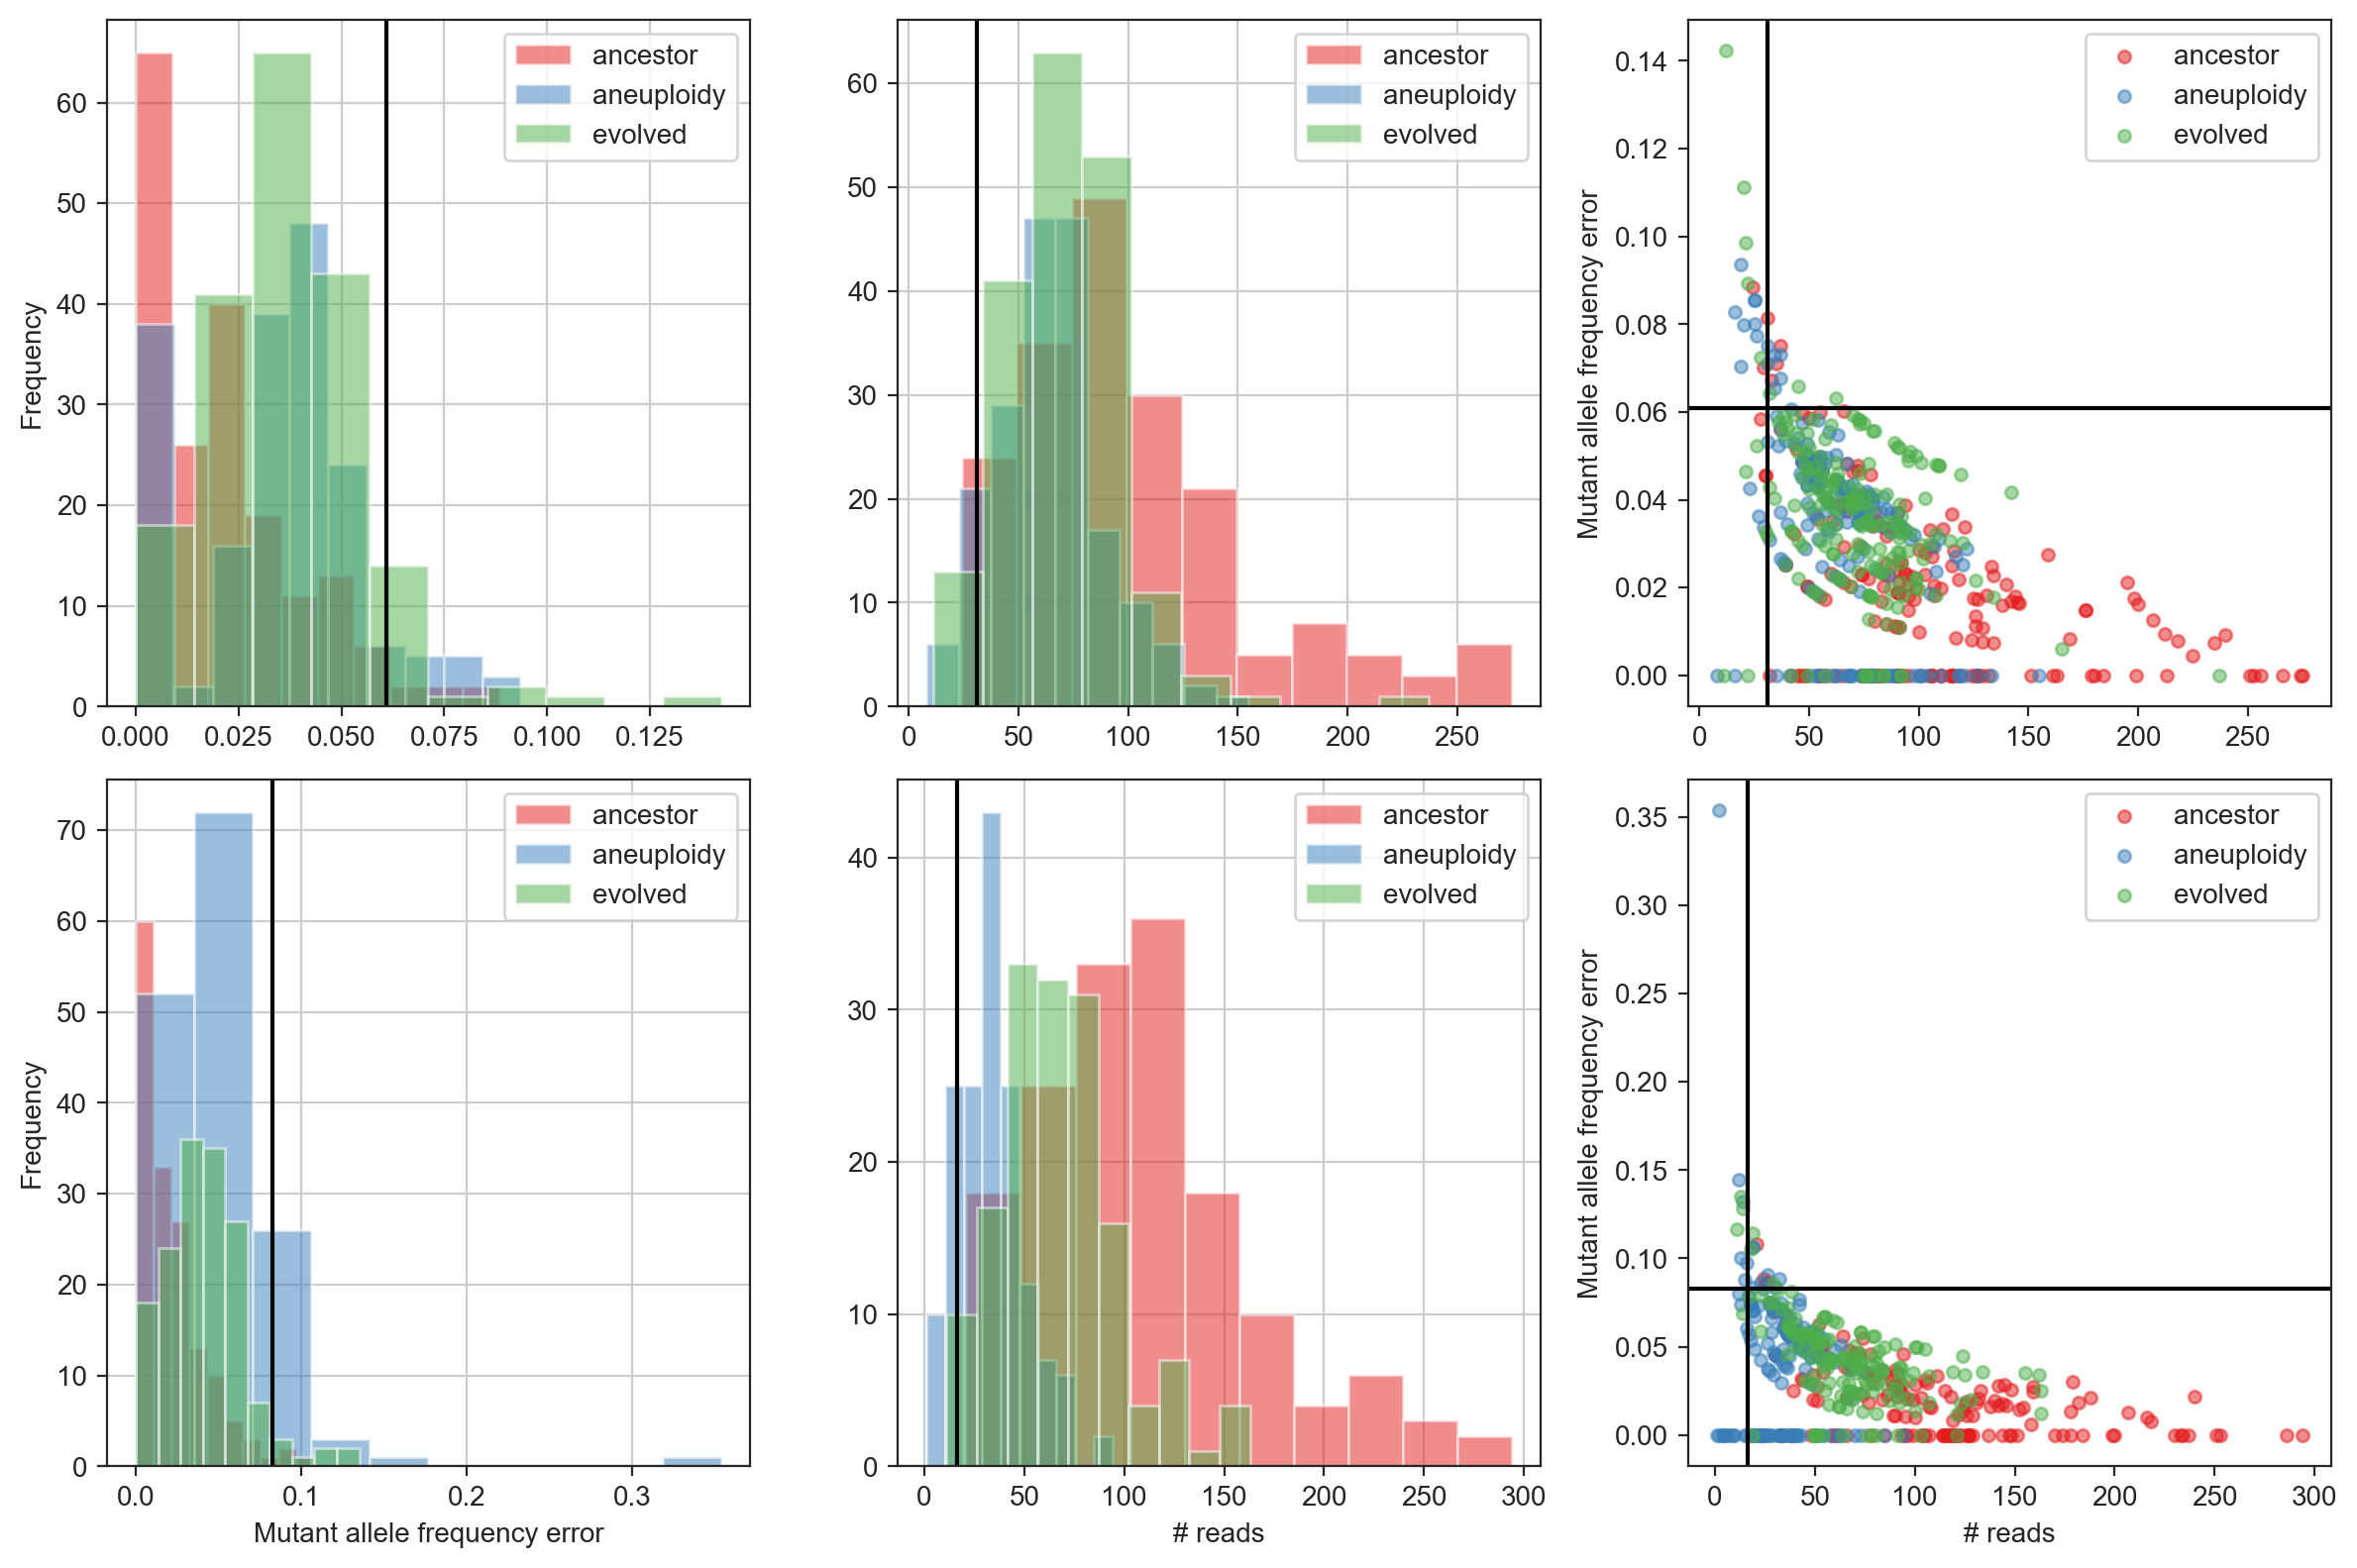

In [152]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
colors = sns.color_palette('Set1', 3)
colors = dict(zip(populations, colors))
alpha = 0.5

for row, data in enumerate([data_B, data_D]):
    total_count = []
    err = []
    for i,t in enumerate(populations):
        total_count.append(data[t+'_total_count'])
        err.append(data[t+'_alt_err'])
    total_count = np.array(total_count)
    err = np.array(err)
    n_q5 = np.percentile(total_count, 5)
    e_q95 = np.percentile(np.array(err), 95)

    ax = axes[row,0]
    for i,t in enumerate(populations):
        c = colors[t]
        data[t+'_alt_err'].hist(ax=ax, alpha=alpha, label=t, color=c)
    ax.axvline(e_q95, color='k')
    ax.legend()
    ax.set_xlabel('Mutant allele frequency error')
    ax.set_ylabel('Frequency')

    ax = axes[row,1]
    for i,t in enumerate(populations):
        c = colors[t]
        data[t+'_total_count'].hist(ax=ax, alpha=alpha, label=t, color=c)
    ax.axvline(n_q5, color='k')
    ax.legend()
    ax.set_xlabel('# reads')

    ax = axes[row,2]
    for i,t in enumerate(populations):
        c = colors[t]
        data.plot.scatter(t+'_total_count', t+'_alt_err', label=t, alpha=alpha, ax=ax, color=c)
    ax.axvline(n_q5, color='k')
    ax.axhline(e_q95, color='k')

    ax.legend()
    ax.set_xlabel('# reads')
    ax.set_ylabel('Mutant allele frequency error')

for i in range(3):
    axes[0,i].set_xlabel('')
fig.tight_layout()

# Analysis

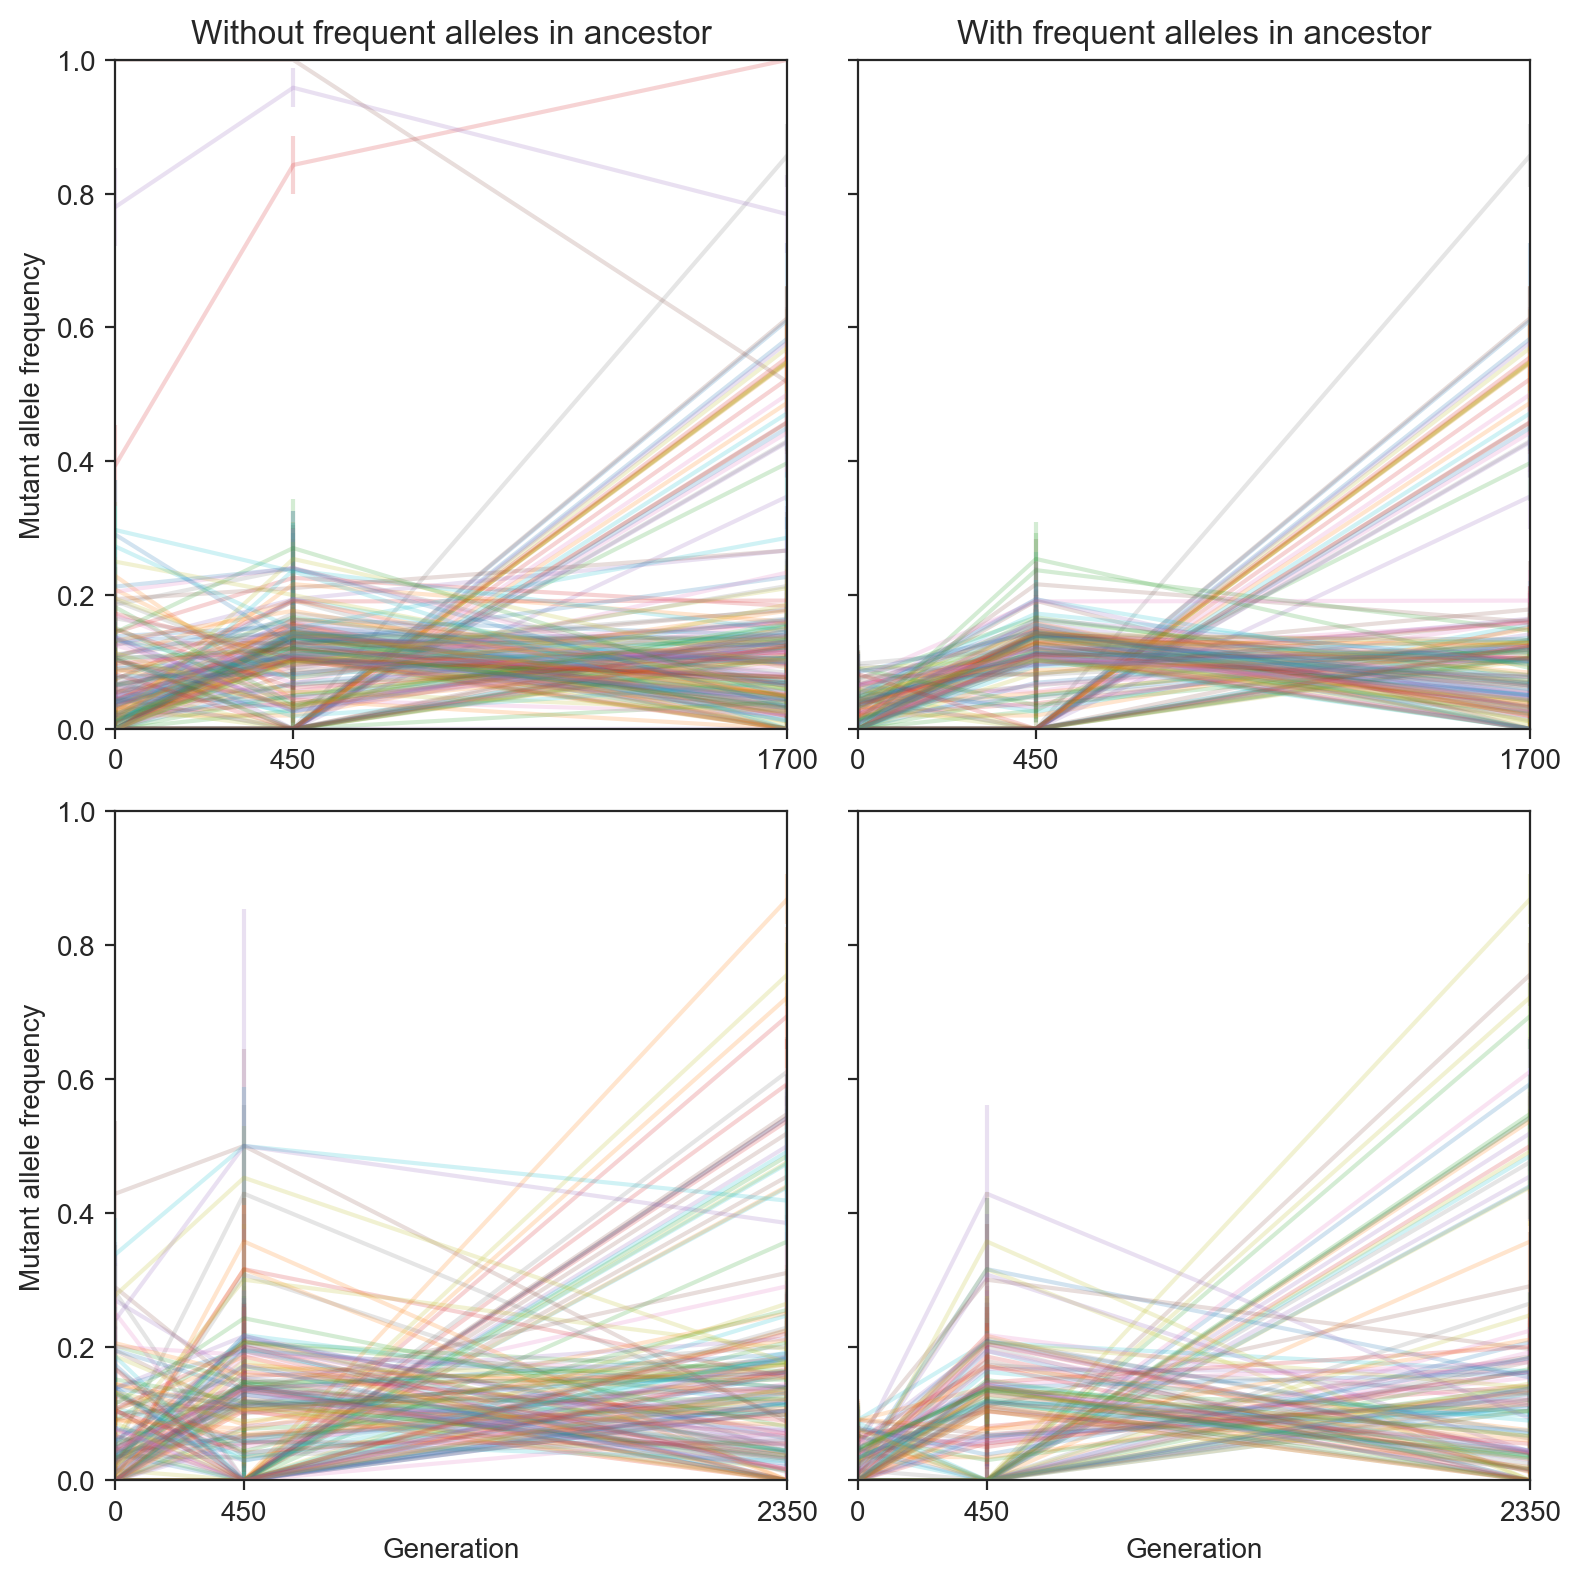

In [153]:
t = [[0, 450, 1700],[0, 450, 2350]]
th = 0.1

fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex='row', sharey=True)
for row, data in enumerate([data_B, data_D]):

    traj = data[['ancestor_alt','aneuploidy_alt','evolved_alt']].values
    err = data[['ancestor_alt_err','aneuploidy_alt_err','evolved_alt_err']].values
    idx = traj[:,0] < th

    for x,e in zip(traj, err):
        axes[row,0].errorbar(t[row], x, yerr=e, alpha=0.2)
    for x,e in zip(traj[idx], err[idx]):
        axes[row,1].errorbar(t[row], x, yerr=e, alpha=0.2)
    axes[row,0].set(
        xticks=t[row], 
        ylim=(0, 1),
        xlim=(t[row][0], t[row][-1]),
        xlabel='Generation',
        ylabel='Mutant allele frequency',
        title='Without frequent alleles in ancestor'
    )
    axes[row,1].set(
        xlabel='Generation',
        title='With frequent alleles in ancestor'
    )
for i in range(2):
    axes[0,i].set_xlabel('')
    axes[1,i].set_title('')
fig.tight_layout()

In [250]:
data = pd.concat([data_B, data_D])
data = data[data.ancestor_alt<0.1]
data.head()

,#CHROM,POS,REF,ALT,ancestor_total_count,ancestor_ref_count,ancestor_alt_count,ancestor_ref,ancestor_alt,ancestor_alt_err,aneuploidy_total_count,aneuploidy_ref_count,aneuploidy_alt_count,aneuploidy_ref,aneuploidy_alt,aneuploidy_alt_err,evolved_total_count,evolved_ref_count,evolved_alt_count,evolved_ref,evolved_alt,evolved_alt_err
0,chr01,230142,G,GTGGGTGT,32,32,0,1.0,0.0,0.0,16,16,0,1.0,0.0,0.0,12,5,7,0.416667,0.583333,0.142319
1,chr02,19393,C,T,253,253,0,1.0,0.0,0.0,121,121,0,1.0,0.0,0.0,119,61,58,0.512605,0.487395,0.045820
2,chr02,534279,C,A,80,80,0,1.0,0.0,0.0,98,98,0,1.0,0.0,0.0,62,28,34,0.451613,0.548387,0.063202
3,chr02,576193,T,A,132,132,0,1.0,0.0,0.0,104,104,0,1.0,0.0,0.0,109,52,57,0.477064,0.522936,0.047841
4,chr04,315072,CT,C,48,48,0,1.0,0.0,0.0,41,41,0,1.0,0.0,0.0,47,42,5,0.893617,0.106383,0.044974


In [251]:
print("high aneuploid ({}) in evolved {}:".format(
    (data.aneuploidy_alt>0.2).sum(), 
    data[(data.aneuploidy_alt>0.2) & (data.evolved_alt>0.15)].evolved_alt.values
))

high aneuploid (18) in evolved [0.16       0.16304348 0.15384615 0.19642857]:


In [252]:
print("high evolved ({}) in aneuploid {}:".format(
    (data.evolved_alt>0.2).sum(), 
    data[(data.evolved_alt>0.2) & (data.aneuploidy_alt>0.01)].aneuploidy_alt.values
))

high evolved (48) in aneuploid [0.02739726 0.11111111 0.07692308]:


In [340]:
from scipy import odr

In [337]:
x = data.aneuploidy_alt.values
y = data.evolved_alt.values
xerr = data.aneuploidy_alt_err.values
xerr[data.aneuploidy_alt==0] = 1e-10
yerr = data.evolved_alt_err.values
yerr[data.evolved_alt==0] = 1e-10

odr_data = odr.RealData(x=x, y=y, sx=xerr, sy=yerr)
odr_result = odr.ODR(odr_data, odr.unilinear, beta0=[0.6, -1.]).run()
odr_result.pprint()

# plt.errorbar(odr_data.x, odr_data.y, odr_data.sx, odr_data.sy, ls='')
# plt.plot(np.linspace(0, 1), linear(odr_result.beta, np.linspace(0, 1)), 'k')
# plt.ylim(0, None);

Beta: [-1.7880901   0.29374265]
Beta Std Error: [0.2633159  0.01857758]
Beta Covariance: [[ 9.47157554e-03 -3.68763994e-04]
 [-3.68763994e-04  4.71461862e-05]]
Residual Variance: 7.320351693412421
Inverse Condition #: 0.05964817237873459
Reason(s) for Halting:
  Sum of squares convergence


Correlation: SpearmanrResult(correlation=-0.6452635246255588, pvalue=5.78787603696765e-18)
Correlation: SpearmanrResult(correlation=-0.6621975689256977, pvalue=1.0326820548226105e-15)
Linear ODR coefficients: a=-1.788, b=0.294


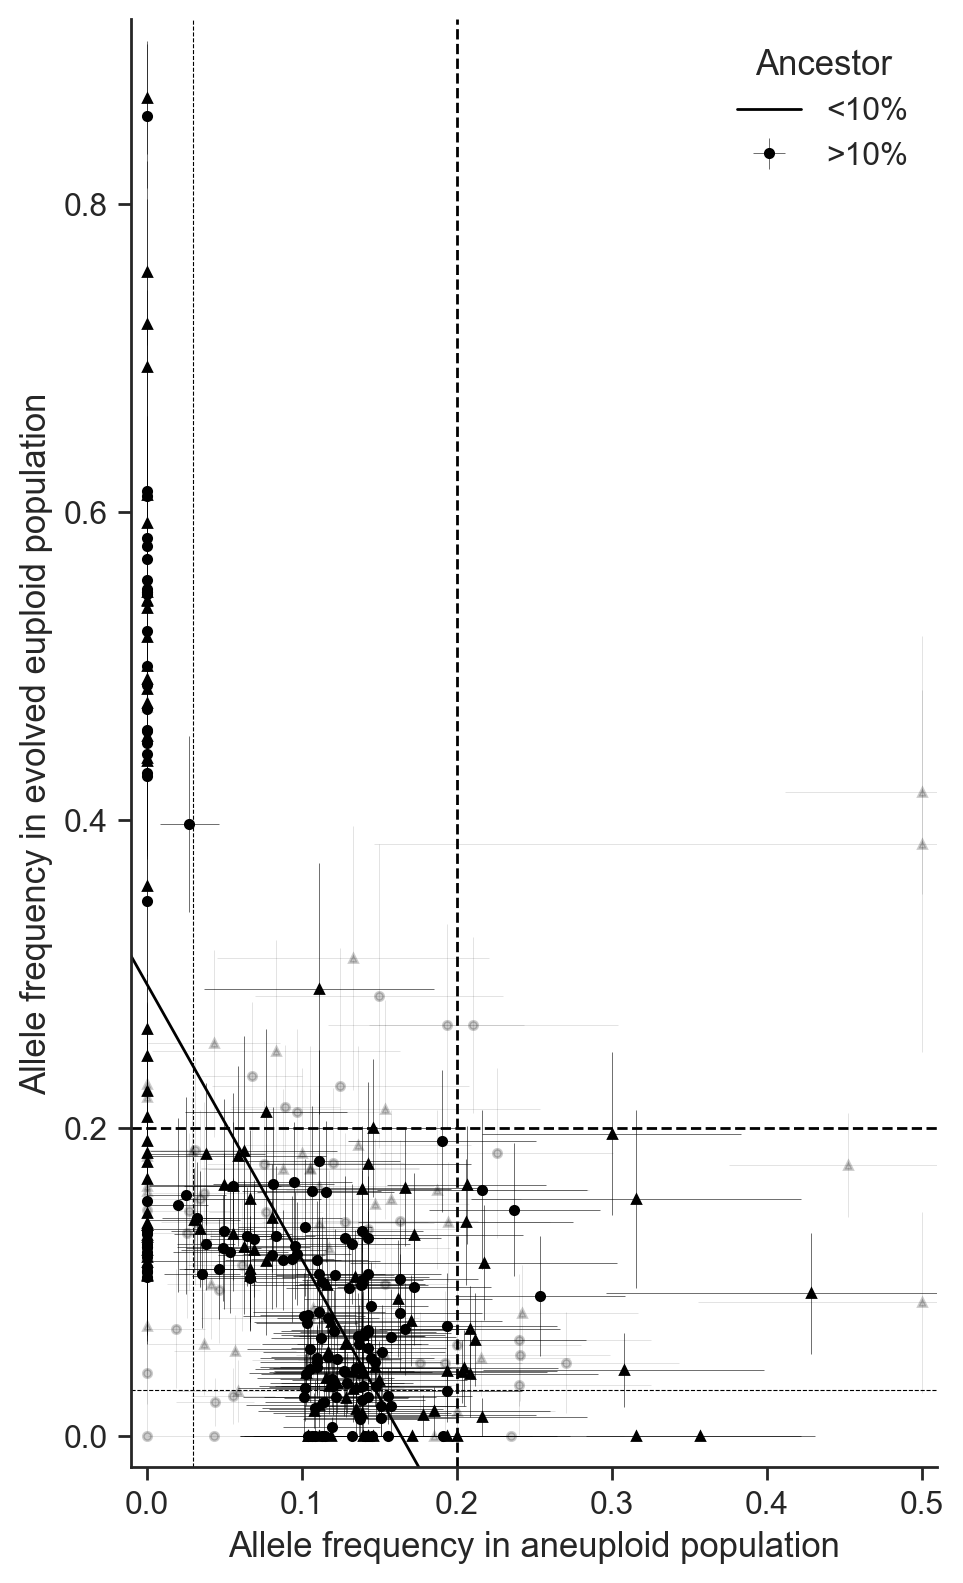

In [338]:
fig, ax = plt.subplots(1, 1, figsize=(10*0.52, 10*0.94))
kwargs = dict(ls='', c='k', elinewidth=0.2, markersize=3)
markers = ['o', '^']

for col, data in enumerate([data_B, data_D]):
    traj = data[['ancestor_alt','aneuploidy_alt','evolved_alt']].values
    err = data[['ancestor_alt_err','aneuploidy_alt_err','evolved_alt_err']].values
    idx = traj[:,0] < th
    
    ax.errorbar(traj[idx, 1], traj[idx, 2], xerr=err[idx,1], yerr=err[idx,2], marker=markers[col], **kwargs)
    ax.errorbar(traj[~idx, 1], traj[~idx, 2], xerr=err[~idx,1], yerr=err[~idx,2], marker=markers[col], alpha=0.2, **kwargs)
    print("Correlation:", scipy.stats.spearmanr(traj[idx, 1], traj[idx, 2]))
    
# ODR
x_fit = np.linspace(-0.1, 1, 1000)
y_fit = linear(odr_result.beta, x_fit)
print("Linear ODR coefficients: a={:.3f}, b={:.3f}".format(*odr_result.beta))
ax.plot(x_fit, y_fit, '-', color='k', lw=1)
    
ax.legend(['<{:.0%}'.format(th), '>{:.0%}'.format(th)], title='Ancestor', frameon=False)
ax.axhline(0.03, color='k', ls='--', lw=0.4)
ax.axvline(0.03, color='k', ls='--', lw=0.4)
ax.axhline(0.2, color='k', ls='--', lw=1)
ax.axvline(0.2, color='k', ls='--', lw=1)
# ax.plot(np.linspace(-1,1), np.linspace(-1,1), ls='--', color='k', lw=0.5)
ax.set(
#     title=['H2','H4'][col],
    xlabel='Allele frequency in aneuploid population',# (t={})'.format(t[col][1]),
    ylabel='Allele frequency in evolved euploid population',# (t={})'.format(t[col][-1]),        
    ylim=(-0.02, 0.92),
    yticks=[0, 0.2, 0.4, 0.6, 0.8],
    xticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5],
    xlim=(-0.01, 0.51),
)
fig_panel_labels(axes, xcoord=-0.17, ycoord=0.95)
sns.despine()
fig.savefig('../figures/mutation_frequencies.pdf')

Correlation: SpearmanrResult(correlation=-0.6452635246255588, pvalue=5.78787603696765e-18)
Correlation: SpearmanrResult(correlation=-0.6621975689256977, pvalue=1.0326820548226105e-15)
Linear ODR coefficients: a=-0.559, b=0.164


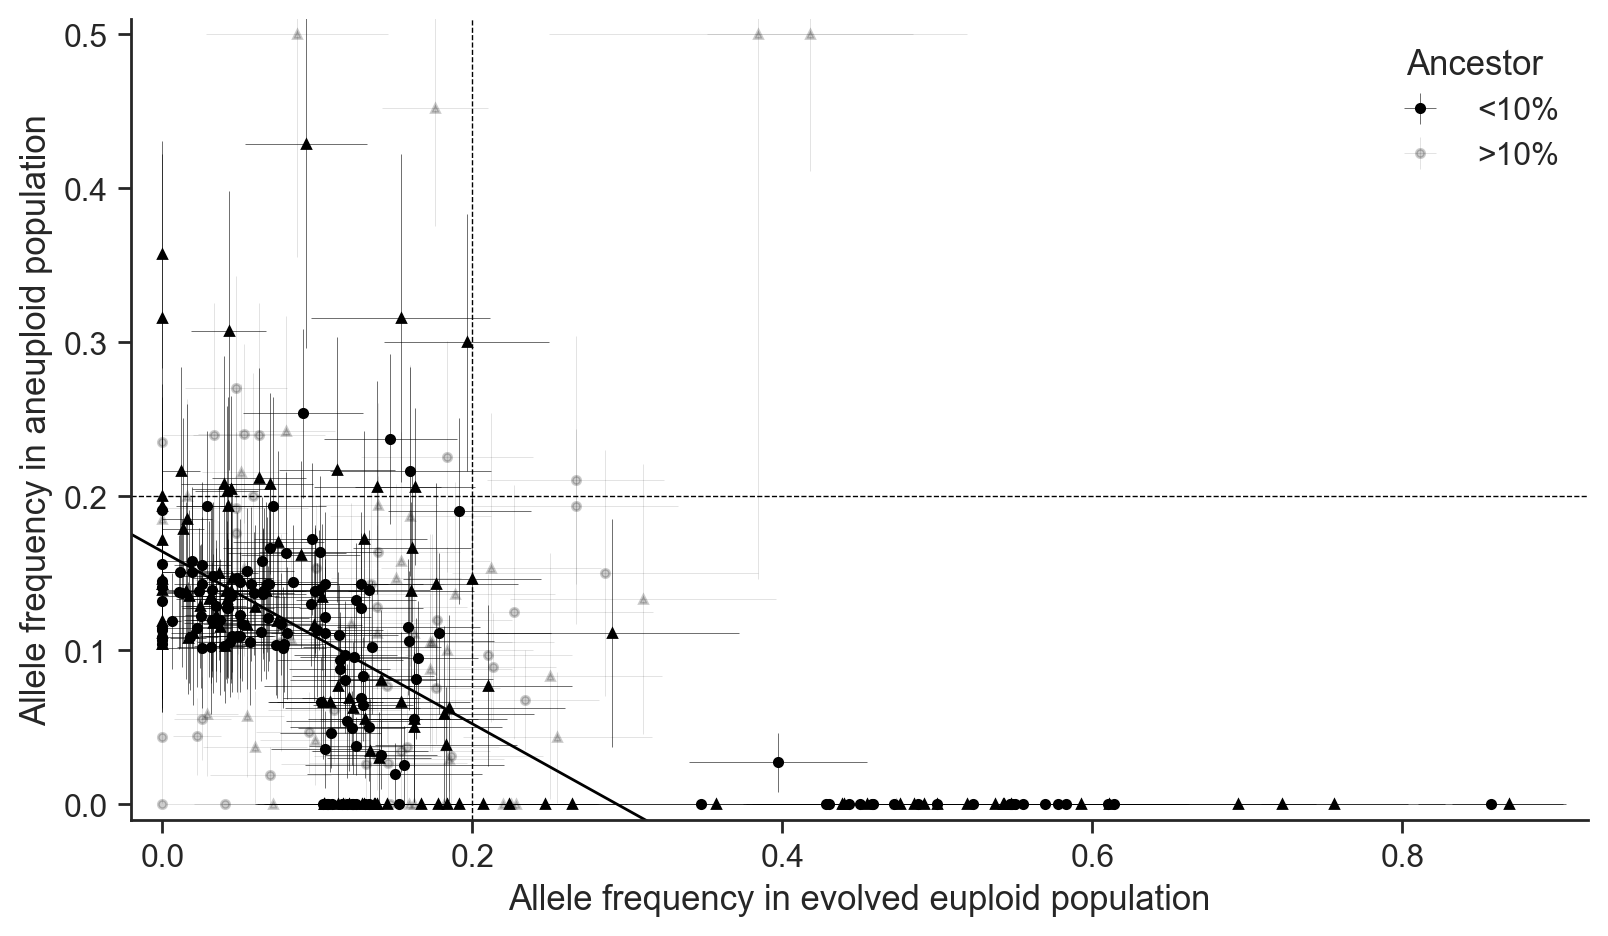

In [341]:
fig, ax = plt.subplots(1, 1, figsize=(10*0.94, 10*0.52))
kwargs = dict(ls='', c='k', elinewidth=0.2, markersize=3)
markers = ['o', '^']

for col, data in enumerate([data_B, data_D]):
    traj = data[['ancestor_alt','aneuploidy_alt','evolved_alt']].values
    err = data[['ancestor_alt_err','aneuploidy_alt_err','evolved_alt_err']].values
    idx = traj[:,0] < th
    
    ax.errorbar(traj[idx, 2], traj[idx, 1], xerr=err[idx,2], yerr=err[idx,1], marker=markers[col], **kwargs)
    ax.errorbar(traj[~idx, 2], traj[~idx, 1], xerr=err[~idx,2], yerr=err[~idx,1], marker=markers[col], alpha=0.2, **kwargs)
    print("Correlation:", scipy.stats.spearmanr(traj[idx, 2], traj[idx, 1]))

ax.legend(['<{:.0%}'.format(th), '>{:.0%}'.format(th)], title='Ancestor', frameon=False)

# ODR
x_fit = np.linspace(-0.1, 1, 1000)
y_fit = linear(odr_result.beta, x_fit)
a, b = odr_result.beta
print("Linear ODR coefficients: a={:.3f}, b={:.3f}".format(1/a, -b/a))
ax.plot(y_fit, x_fit, '-', color='k', lw=1)
    
# ax.axhline(0.03, color='k', ls='--', lw=0.4)
# ax.axvline(0.03, color='k', ls='--', lw=0.4)
ax.axhline(0.2, color='k', ls='--', lw=1/2)
ax.axvline(0.2, color='k', ls='--', lw=1/2)
# ax.plot(np.linspace(-1,1), np.linspace(-1,1), ls='--', color='k', lw=0.5)
ax.set(
#     title=['H2','H4'][col],
    ylabel='Allele frequency in aneuploid population',# (t={})'.format(t[col][1]),
    xlabel='Allele frequency in evolved euploid population',# (t={})'.format(t[col][-1]),        
    xlim=(-0.02, 0.92),
    xticks=[0, 0.2, 0.4, 0.6, 0.8],
    yticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5],
    ylim=(-0.01, 0.51),
)
fig_panel_labels(axes, xcoord=-0.17, ycoord=0.95)
sns.despine()
fig.savefig('../figures/mutation_frequencies.pdf')

In [334]:
odr?

Type:        module
String form: <module 'scipy.odr' from '/Users/yoavram/miniconda3/envs/scipy/lib/python3.8/site-packages/scipy/odr/__init__.py'>
File:        ~/miniconda3/envs/scipy/lib/python3.8/site-packages/scipy/odr/__init__.py
Docstring:  
Orthogonal distance regression (:mod:`scipy.odr`)

.. currentmodule:: scipy.odr

Package Content

.. autosummary::
   :toctree: generated/

   Data          -- The data to fit.
   RealData      -- Data with weights as actual std. dev.s and/or covariances.
   Model         -- Stores information about the function to be fit.
   ODR           -- Gathers all info & manages the main fitting routine.
   Output        -- Result from the fit.
   odr           -- Low-level function for ODR.

   OdrWarning    -- Warning about potential problems when running ODR.
   OdrError      -- Error exception.
   OdrStop       -- Stop exception.

   polynomial    -- Factory function for a general polynomial model.
   exponential   -- Exponential model
   multiline